In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
from torch.autograd import Variable

import torchvision.transforms as transforms
import torchvision.models as models

from PIL import Image
from skimage import color
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import zoom

from colormath.color_objects import AdobeRGBColor, sRGBColor, LabColor
from colormath.color_conversions import convert_color

%matplotlib inline

In [2]:
image = Image.open('data/goat-on-grass.jpg')
image = image.resize((256, 256))

In [3]:
image_rgb = np.array(image)
image_lab = color.rgb2lab(image_rgb)
image_lab = image_lab.transpose(2, 0, 1)

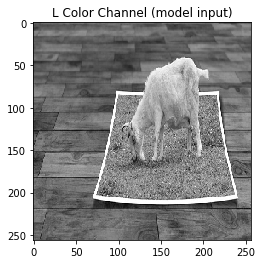

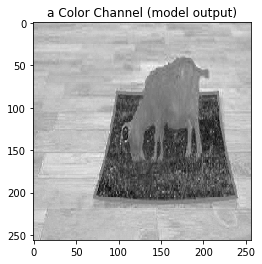

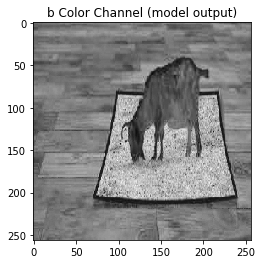

In [4]:
plt.figure()
plt.title('L Color Channel (model input)')
plt.imshow(image_lab[0, :, :], cmap='gray')

plt.figure()
plt.title('a Color Channel (model output)')
plt.imshow(image_lab[1, :, :], cmap='gray')

plt.figure()
plt.title('b Color Channel (model output)')
plt.imshow(image_lab[2, :, :], cmap='gray')

In [40]:
class ColorizationDataset(data.Dataset):
    def __init__(self, image_size=256):
        super(ColorizationDataset, self).__init__()
        self.image_size = image_size
        self.img_names = []
    
    def __getitem__(self, index):
        image = Image.open(self.img_names[index])
        image = image.resize((self.image_size, self.image_size))
        image_rgb = np.array(image)
        image_lab = color.rgb2lab(image_rgb)
        image_lab = image_lab.transpose(2, 0, 1)
        
        input, label = image_lab[:, :, 0] - 50, image_lab[:, :, 1:]
        label = zoom(label, 64 / self.image_size)
        return torch.FloatTensor(input), torch.FloatTensor(label)
    
    def __len__(self):
        return len(self.img_names)

In [41]:
class ImageColorizer(nn.Module):
    def __init__(self, temperature=0.38):
        super(ImageColorizer, self).__init__()
        
        self.moduleList = nn.ModuleList()
        self.moduleList.append(self.conv_block(1, 64, 2, downsample=True))
        self.moduleList.append(self.conv_block(64, 128, 2, downsample=True))
        self.moduleList.append(self.conv_block(128, 256, 3, downsample=True))
        self.moduleList.append(self.conv_block(256, 512, 3))
        self.moduleList.append(self.conv_block(512, 512, 3, dilation=2, padding=2))
        self.moduleList.append(self.conv_block(512, 512, 3, dilation=2, padding=2))
        self.moduleList.append(self.conv_block(512, 512, 3))
        self.moduleList.append(self.deconv_block())
                         
        self.conv_class = nn.Conv2d(256, 2, 1)
        self.temperature = temperature
        
    def conv_block(self, in_dim, out_dim, n_convs, dilation=1, padding=1, downsample=False):
        block = []
        for i in range(0, n_convs):
            if i == 0:
                in_feat, stride = in_dim, 1
            elif i == n_convs - 1:
                in_feat, stride = out_dim, 2 if downsample else 1
            else:
                in_feat, stride = out_dim, 1
                
            block.append(nn.Conv2d(in_feat, out_dim, 3, padding=padding, stride=stride, dilation=dilation))
            block.append(nn.ReLU(inplace=True))

        block.append(nn.BatchNorm2d(out_dim))
        return nn.Sequential(*block)
    
    def deconv_block(self):
        block = []
        block.append(nn.ConvTranspose2d(512, 256, 4, padding=1, stride=2))
        block.append(nn.ReLU(inplace=True))
        block.append(nn.Conv2d(256, 256, 3, padding=1))
        block.append(nn.ReLU(inplace=True))
        block.append(nn.Conv2d(256, 256, 3, padding=1))
        block.append(nn.ReLU(inplace=True))
        return nn.Sequential(*block)
    
    def forward(self, input):
        for m in self.moduleList:
            input = m(input)

        input = self.conv_class(input)
        input *= 1 / self.temperature        
        return input

In [31]:
model = ImageColorizer()

In [32]:
X = image_lab[0, :, :]
X = torch.FloatTensor(X)
X = X.unsqueeze(0).unsqueeze(0)

In [33]:
X = Variable(X)
Y = model(X)
Y = Y.squeeze(0).data.numpy().transpose(1, 2, 0)
Y = zoom(Y, (4, 4, 1))

In [34]:
Y.shape

(256, 256, 2)

In [35]:
image = np.zeros((256, 256, 3))
image[:, :, 0] = image_lab[0, :, :]
image[:, :, 1:] = Y

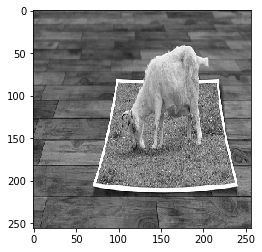

In [36]:
plt.imshow(color.lab2rgb(image))

In [44]:
def train_model(model, optimizer, criterion, num_epochs=10, show_every=20):
    for epoch in range(num_epochs):
        print('Epoch %s' % epoch)
        print('=' * 10)
        
        running_loss = []
        for i, data in enumerate(iter(loader)):
            input, labels = data
            input, labels = Variable(input), Variable(labels)
            output = model(input)
            
            optim.zero_grad()
            loss = criterion(output, labels)
            loss.backward()
            
            optim.step()
            
            running_loss.append(loss.data[0])
            if i % show_every == 0:
                print('Iter %s: %s' % (i, np.mean(running_loss)))
    
    return model

In [43]:
model = ImageColorizer()
optimizer = optim.RMSprop(model.parameters())
criterion = nn.MSELoss()

dset = ColorizationDataset()
loader = data.DataLoader(dset, shuffle=True, batch_size=4)

In [ ]:
model = train_model(model, optimizer, criterion)

In [47]:
def predict(model, L):
    input = Variable(L)
    out = model(L).data.squeeze(0).numpy()
    out = zoom(out, 4)
    img = np.concat((L, out)).transpose(1, 2, 0)
    img = color.lab2rgb(img)
    
    plt.figure()
    plt.imshow(L, cmap='gray')
    
    plt.figure()
    plt.imshow(img)

In [ ]:
predict(model, torch.FloatTensor(image_lab[0, :, :]))